# ARIMA Model (Autoregressive Integrated Moving Average)

In [75]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datetime import timedelta
from sqlalchemy import create_engine
import psycopg2
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from config import db_password
import numpy as np

## Load in Data

In [59]:
# database address
host_name = 'database-1.cvhixt1fojqo.us-east-1.rds.amazonaws.com'

# create the database engine
db_string = f"postgresql://postgres:{db_password}@{host_name}:5432/Crypto_Data"

engine = create_engine(db_string)

In [60]:
crypto_df = pd.read_sql("SELECT * FROM crypto_orig", con=engine)

In [61]:
crypto_df.shape

(5012, 9)

In [62]:
crypto_df.dtypes

type_crypto       object
date_orig         object
daystarttoend      int64
open_            float64
high_            float64
low_             float64
close_           float64
volume_          float64
marketcap_       float64
dtype: object

In [63]:
crypto_df.sample(10)

,type_crypto,date_orig,daystarttoend,open_,high_,low_,close_,volume_,marketcap_
2292,eth,2019-06-18,625,274.140674,274.140674,264.132903,266.297054,6.598080e+09,2.864443e+10
334,ada,2018-09-01,335,0.101799,0.109058,0.101697,0.107167,5.394663e+07,2.739417e+09
1349,ada,2021-06-12,1350,1.440000,1.491243,1.360686,1.480000,2.458705e+09,4.513956e+10
2908,eth,2021-02-23,1241,1776.284613,1777.488304,1409.685341,1560.590131,9.304354e+10,1.810000e+11
2439,eth,2019-11-12,772,184.938028,186.935048,183.338876,186.732465,6.653371e+09,2.014541e+10
4142,xrp,2019-12-09,799,0.229142,0.230003,0.221691,0.224204,8.629348e+08,9.822858e+09
4274,xrp,2020-04-19,931,0.194979,0.195060,0.188906,0.189747,1.236574e+09,8.314728e+09
1320,ada,2021-05-14,1321,1.933580,2.036812,1.820000,2.010000,9.180651e+09,5.991845e+10
3722,xrp,2018-10-15,379,0.405691,0.488479,0.398670,0.442429,7.704973e+08,1.735441e+10
2858,eth,2021-01-04,1191,976.801807,1152.226308,916.755033,1040.789197,9.991489e+10,1.160000e+11


## Transform Data

In [64]:
crypto_df['date_orig'] = pd.to_datetime(crypto_df["date_orig"])
crypto_df.dtypes

type_crypto              object
date_orig        datetime64[ns]
daystarttoend             int64
open_                   float64
high_                   float64
low_                    float64
close_                  float64
volume_                 float64
marketcap_              float64
dtype: object

## Split data by type

In [65]:
crypto_list = crypto_df['type_crypto'].unique()
crypto_list

array(['ada', 'eth', 'xrp'], dtype=object)

## ARIMA Model Function

In [66]:
def ARIMApricepredict(df, dt, crypto_name='NA'):
    
    # number of future days to predict
    dt_days = dt
    
    # features
    X = df[['date_orig','close_']]
    # set index to time series
    X.set_index('date_orig', inplace=True)
    
    # time series model
    ARIMAmodel = ARIMA(X, order = (2,2,1))
    
    # fit or train the data
    ARIMAmodel = ARIMAmodel.fit()
    
    # creating validation output series
    X_pred_df = ARIMAmodel.predict(start = X.index[0], end = X.index[-1])
    
    # creating future output series
    pred = ARIMAmodel.get_forecast(dt_days)
    pred_df = pred.conf_int(alpha = 0.05) 
    pred_df["Predictions"] = ARIMAmodel.predict(start = pred_df.index[0], end = pred_df.index[-1])
    future_pred_out = pred_df["Predictions"]
    
    # combining predict series
    pred_combined = X_pred_df.append(future_pred_out)
    pred_combined_df = pd.DataFrame(pred_combined,columns=['close_pred_ARIMA'])
    pred_combined_df['type_crypto'] = crypto_name
    
    # creating final predict dataframe
    predict_clean_df = df[['type_crypto','date_orig','close_']]
    predict_clean_df = predict_clean_df.merge(pred_combined_df, how='right', left_on='date_orig', right_index=True)
    predict_clean_df = predict_clean_df[['type_crypto_y','date_orig','close_','close_pred_ARIMA']]
    predict_clean_df = predict_clean_df.rename(columns={'type_crypto_y':'type_crypto','date_orig':'date','close_':'close_orig'})
    predict_clean_df.reset_index(drop=True, inplace=True)
    
    return predict_clean_df

## Model Testing with ADA

In [67]:
test_df = crypto_df.loc[crypto_df['type_crypto'] == 'eth',:]
test_predict_60_day = ARIMApricepredict(test_df, 60, crypto_name='eth')

/Users/briancha/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/briancha/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/briancha/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/briancha/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [68]:
test_predict_60_day

,type_crypto,date,close_orig,close_pred_ARIMA
0,eth,2017-10-02,296.380814,0.000000
1,eth,2017-10-03,291.676198,444.485590
2,eth,2017-10-04,293.705334,289.128747
3,eth,2017-10-05,294.677511,293.012850
4,eth,2017-10-06,307.934787,294.734296
...,...,...,...,...
1731,eth,2022-06-29,NaN,3023.269509
1732,eth,2022-06-30,NaN,3024.852035
1733,eth,2022-07-01,NaN,3026.434560
1734,eth,2022-07-02,NaN,3028.017086


## Model Output

In [69]:
#initial output tables
predict_df_60_day = pd.DataFrame()
predict_df_30_day = pd.DataFrame()

In [70]:
# for loop to separate models
for crypto in crypto_list:
    
    # run the ML models
    df = crypto_df.loc[crypto_df['type_crypto'] == crypto,:]
    predict_60_day = ARIMApricepredict(df, 60, crypto_name=crypto)
    predict_30_day = ARIMApricepredict(df, 30, crypto_name=crypto)
    
    # create the output dataframes
    predict_df_60_day = predict_df_60_day.append(predict_60_day, ignore_index=True)
    predict_df_30_day = predict_df_30_day.append(predict_30_day, ignore_index=True)

/Users/briancha/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/briancha/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/briancha/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/briancha/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/briancha/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/st

In [71]:
predict_df_30_day.tail(50)

,type_crypto,date,close_orig,close_pred_ARIMA
5052,xrp,2022-04-07,0.787914,0.759840
5053,xrp,2022-04-08,0.754096,0.788000
5054,xrp,2022-04-09,0.763062,0.753630
5055,xrp,2022-04-10,0.762818,0.762959
5056,xrp,2022-04-11,0.694468,0.763335
5057,xrp,2022-04-12,0.717054,0.691947
5058,xrp,2022-04-13,0.723957,0.716675
5059,xrp,2022-04-14,0.725771,0.725060
5060,xrp,2022-04-15,0.785042,0.726302
5061,xrp,2022-04-16,0.781577,0.787837


In [72]:
predict_df_60_day.tail(50)

,type_crypto,date,close_orig,close_pred_ARIMA
5142,xrp,2022-05-07,NaN,0.639310
5143,xrp,2022-05-08,NaN,0.639570
5144,xrp,2022-05-09,NaN,0.639830
5145,xrp,2022-05-10,NaN,0.640091
5146,xrp,2022-05-11,NaN,0.640351
5147,xrp,2022-05-12,NaN,0.640612
5148,xrp,2022-05-13,NaN,0.640872
5149,xrp,2022-05-14,NaN,0.641132
5150,xrp,2022-05-15,NaN,0.641393
5151,xrp,2022-05-16,NaN,0.641653


In [73]:
predict_df_30_day.tail(50)

,type_crypto,date,close_orig,close_pred_ARIMA
5052,xrp,2022-04-07,0.787914,0.759840
5053,xrp,2022-04-08,0.754096,0.788000
5054,xrp,2022-04-09,0.763062,0.753630
5055,xrp,2022-04-10,0.762818,0.762959
5056,xrp,2022-04-11,0.694468,0.763335
5057,xrp,2022-04-12,0.717054,0.691947
5058,xrp,2022-04-13,0.723957,0.716675
5059,xrp,2022-04-14,0.725771,0.725060
5060,xrp,2022-04-15,0.785042,0.726302
5061,xrp,2022-04-16,0.781577,0.787837


## Model Accuracy

In [77]:
# Accuracy by Root Ream Squared Error
rmse = np.mean((predict_df_30_day['close_pred_ARIMA'] - predict_df_30_day['close_orig'])**2)**.5
print(f'The root mean squared error is {rmse}')

The root mean squared error is 45.51391996817535


In [81]:
#Accuracy by Mean Absolute Percentage Error

mape = np.mean(np.abs((predict_df_30_day['close_pred_ARIMA'] - predict_df_30_day['close_orig'])/np.abs(predict_df_30_day['close_orig'])))
print(f'The root mean squared error is {mape}')

The root mean squared error is 0.04086150681870837


## High Level Visualization

In [49]:
ada_predict_df_30_day = predict_df_30_day.loc[predict_df_30_day['type_crypto'] == 'ada',:]
ada_predict_df_60_day = predict_df_60_day.loc[predict_df_60_day['type_crypto'] == 'ada',:]

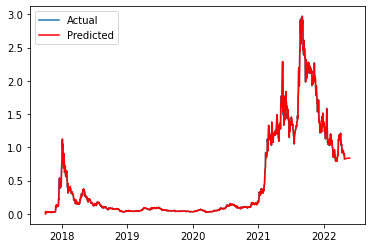

In [50]:
# TABLEAU VISUALIZATION
plt.plot(ada_predict_df_30_day.date, ada_predict_df_30_day.close_orig)
plt.plot(ada_predict_df_30_day.date, ada_predict_df_30_day.close_pred_ARIMA, color='red')
plt.legend(["Actual", "Predicted"])
plt.show()

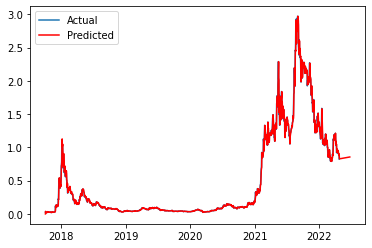

In [51]:
# TABLEAU VISUALIZATION
plt.plot(ada_predict_df_60_day.date, ada_predict_df_60_day.close_orig)
plt.plot(ada_predict_df_60_day.date, ada_predict_df_60_day.close_pred_ARIMA, color='red')
plt.legend(["Actual", "Predicted"])
plt.show()

## Removing Timestamp

In [52]:
predict_df_60_day['date'] = predict_df_60_day['date'].dt.date

In [53]:
predict_df_30_day['date'] = predict_df_30_day['date'].dt.date

## Model & Actual Difference

In [54]:
delta = predict_df_60_day['close_pred_ARIMA'] - predict_df_60_day['close_orig']
delta

0      -0.025808
1       0.017886
2      -0.006128
3      -0.001687
4       0.001657
          ...   
5187         NaN
5188         NaN
5189         NaN
5190         NaN
5191         NaN
Length: 5192, dtype: float64

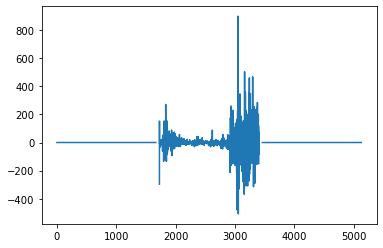

In [55]:
# TABLEAU VISUALIZATION
plt.plot(delta)
plt.show()

## Send to Postgres

In [56]:
predict_df_60_day.to_sql(name='predict_df_60_day_arima', index=False, con=engine)

In [57]:
predict_df_30_day.to_sql(name='predict_df_30_day_arima', index=False, con=engine)